## Code

In [1]:
import pandas
import numpy as np
import math

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Note: forces*R != moments since the center of force may change!
# Note: It's ok that many of these results will have negative Cp... haris had 3 out of 250 with positive results!

In [4]:
def convert_to_num(xyz):
    """Converts x->0, y->1, z->2. Throws an Exception otherwise."""
    if 'x'==xyz:
        return 0
    elif 'y'==xyz:
        return 1
    elif 'z'==xyz:
        return 2
    raise Exception('coord must be "x", "y", or "z"')

In [5]:
def test_convert_to_num():
    """Ensures convert_to_num works as expected."""
    assert 0 == convert_to_num('x')
    assert 1 == convert_to_num('y')
    assert 2 == convert_to_num('z')
    try:
        convert_to_num('w')
        assert False, "Should throw error"
    except AssertionError:
        assert False, "Should throw error"
    except:
        pass

test_convert_to_num()

In [6]:
def get_times_values(filename, coord):
    """Reads filename as Pandas DF and gets columns for time and total_{coord}"""
    f = pandas.read_csv(filename, sep='\t', header=3)
    f = f.rename(columns=lambda x: x.strip())
    times = f["# Time"]
    values = [float(i.strip(",").strip("(),").split(" ")[convert_to_num(coord)]) for i in f["(total_x total_y total_z)"]]
    return times, values 

In [7]:
def filter_to_settled(times, values):
    """Transient part assumed to be 2/3 of simulation. Filter to (at most) last 1/3 of points."""
    num_points = len(times)
    print("Total points:", num_points)
    critical_point = math.ceil(2*num_points/3)
    print("Points used:", num_points - critical_point)
    return times[critical_point:], values[critical_point:]

In [8]:
def test_filter_to_settled():
    """Ensures filter_to_settled chooses up to (but not more than) 1/3 of total points."""
    for i in [0,1]:
        assert 2 == len(filter_to_settled(list(range(7)), list(range(7)))[i])
        assert 2 == len(filter_to_settled(list(range(8)), list(range(8)))[i])
        assert 3 == len(filter_to_settled(list(range(9)), list(range(9)))[i])
        assert 0 == len(filter_to_settled(list(range(2)), list(range(2)))[i])
    
test_filter_to_settled()

Total points: 7
Points used: 2
Total points: 8
Points used: 2
Total points: 9
Points used: 3
Total points: 2
Points used: 0
Total points: 7
Points used: 2
Total points: 8
Points used: 2
Total points: 9
Points used: 3
Total points: 2
Points used: 0


In [9]:
def filter_to_half_rotations(times, values, omega):
    """Filters to a positive integer of half rotations of the given data, to keep data even across 0<=θ<π."""
    half_rotation_time=math.pi/abs(omega)
    print("Time in a half rotation (seconds):", half_rotation_time)
    num_half_rotations =(list(times)[-1] - list(times)[0]) / half_rotation_time
    print("Number of half rotations:", num_half_rotations)
    if num_half_rotations < 1:
        raise Exception("Data must contain at least 1 half-rotation")
    filtered_times = times[times < (list(times)[0] + math.floor(num_half_rotations)*half_rotation_time)]
    filtered_values = list(values)[:len(filtered_times)]
    print("Filtering to " + str(len(filtered_times)) + " points")
    return filtered_times, filtered_values

In [10]:
def test_filter_to_half_rotations():
    """Ensures filter_to_half_rotations filters the correct amount of points."""
    for i in [0,1]:
        assert 18 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), -math.pi/3)[i])
        assert 18 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/2)[i])
        assert 10 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/10)[i]), "Should round down (1 point from next half-rot must exist)"
        assert 20 == len(filter_to_half_rotations(pandas.Series(range(21)), pandas.Series(range(21)), math.pi/10)[i])
        assert 14 == len(filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/7)[i])
    try:
        filter_to_half_rotations(pandas.Series(range(20)), pandas.Series(range(20)), math.pi/30)
        assert False, "Should throw error"
    except AssertionError:
        assert False, "Should throw error"
    except:
        pass
        
test_filter_to_half_rotations()

Time in a half rotation (seconds): 3.0
Number of half rotations: 6.333333333333333
Filtering to 18 points
Time in a half rotation (seconds): 2.0
Number of half rotations: 9.5
Filtering to 18 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 1.9
Filtering to 10 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 2.0
Filtering to 20 points
Time in a half rotation (seconds): 7.0
Number of half rotations: 2.7142857142857144
Filtering to 14 points
Time in a half rotation (seconds): 3.0
Number of half rotations: 6.333333333333333
Filtering to 18 points
Time in a half rotation (seconds): 2.0
Number of half rotations: 9.5
Filtering to 18 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 1.9
Filtering to 10 points
Time in a half rotation (seconds): 10.0
Number of half rotations: 2.0
Filtering to 20 points
Time in a half rotation (seconds): 7.0
Number of half rotations: 2.7142857142857144
Filtering to 14 points
Time in a half rot

In [11]:
def analyze(filename, omega, coord, plot=False):
    """Gets settled values in integer half-rotations, and plots them."""
    times, values = get_times_values(filename, coord)
    if values[-1] > 1e5:
        raise Exception("Data may be corrupted; last value is " + str(values[-1]))

    settled_times, settled_values = filter_to_settled(times, values)
    if plot:
        plt.plot(settled_times, settled_values)
        plt.title(filename + " (" + coord + ")")
        plt.xlabel("simulated time (s)")
        plt.ylabel("total in %s" % coord)

    half_rotation_times, half_rotation_values = filter_to_half_rotations(settled_times, settled_values, omega)
    if plot:
        plt.plot(half_rotation_times, half_rotation_values)

    return half_rotation_values

In [12]:
# Note: Theoretical max power = 0.5 rho A v^3
#                             = 0.5 1 (2rh) v^3 (rho normalized; 1 kg/m^3)
#                             = r v^3 (h=1m)
THEORETICAL_MAX = 1 * 0.75 * (10**3)
print(THEORETICAL_MAX)

750.0


In [13]:
def calc_cp(values, omega):
    """Calculates coefficient of performance. Assumes values are moments (torques) in SI units."""
    torque = np.mean(values)
    power = torque*omega
    Cp = power/THEORETICAL_MAX
    print("Average torque (Nm):", torque)
    print("Average power (W):", power)
    print("Cp:", Cp)

## Results

In [14]:
import glob
import traceback

In [15]:
files = glob.glob('/Users/kmarwaha/testv/*.moment.dat')

In [16]:
for file in files:
    try:
        print(file)
        tsr = file.split('/')[-1].split('_')[2]
        omega = float(tsr)*40/3
        print('omega: ' + str(omega))
        values = analyze(file, omega, 'z')
        calc_cp(values, omega)
        print('')
    except:
        traceback.print_exc()

/Users/kmarwaha/testv/ah79k143_tsr_4.3338_aoa_-0.20091.moment.dat
omega: 57.784
Total points: 261051
Points used: 87017
Time in a half rotation (seconds): 0.05436786400369987
Number of half rotations: 48.335229793489155
Filtering to 86413 points
Average torque (Nm): -2.720916196199614
Average power (W): -157.22542148119848
Cp: -0.20963389530826465

/Users/kmarwaha/testv/ag11_tsr_4.7595_aoa_-6.2281.moment.dat
omega: 63.46
Total points: 238783
Points used: 79594
Time in a half rotation (seconds): 0.04950508436164187
Number of half rotations: 44.21379194125682
Filtering to 79209 points
Average torque (Nm): -23.23265428474037
Average power (W): -1474.344240909624
Cp: -1.9657923212128319

/Users/kmarwaha/testv/ah81131_tsr_0.96329_aoa_9.6549.moment.dat
omega: 12.843866666666665
Total points: 261046
Points used: 87015
Time in a half rotation (seconds): 0.24459866604992733
Number of half rotations: 26.68064427901625
Filtering to 84795 points
Average torque (Nm): -1.4900316093516954
Average pow

Traceback (most recent call last):
  File "<ipython-input-16-046b1dc2f409>", line 7, in <module>
    values = analyze(file, omega, 'z')
  File "<ipython-input-11-0091e9d69c6d>", line 5, in analyze
    raise Exception("Data may be corrupted; last value is " + str(values[-1]))
Exception: Data may be corrupted; last value is 5.055246e+196


Total points: 249945
Points used: 83315
Time in a half rotation (seconds): 0.047934949143352425
Number of half rotations: 46.28463907127521
Filtering to 82802 points
Average torque (Nm): -23.50698380193111
Average power (W): -1540.6163757334955
Cp: -2.0541551676446606

/Users/kmarwaha/testv/apex16_tsr_3.1054_aoa_-0.28914.moment.dat
omega: 41.40533333333333
Total points: 251225
Points used: 83741
Time in a half rotation (seconds): 0.07587410607948557
Number of half rotations: 46.51970523781005
Filtering to 82805 points
Average torque (Nm): -1.2488528139899682
Average power (W): -51.70916704752596
Cp: -0.06894555606336794

/Users/kmarwaha/testv/ah93w174_tsr_3.7705_aoa_-5.7957.moment.dat
omega: 50.27333333333333
Total points: 251306
Points used: 83768
Time in a half rotation (seconds): 0.06249023976110184
Number of half rotations: 46.54151194040351
Filtering to 82793 points
Average torque (Nm): -11.730926597182686
Average power (W): -589.7527831290308
Cp: -0.7863370441720411

/Users/kmarw

### As an example

Total points: 145014
Points used: 48338
Time in a half rotation (seconds): 0.05351946598960466
Number of half rotations: 26.851146464711125
Filtering to 46805 points
Average torque (Nm): -5.773991597008867
Average power (W): -338.93330674442046
Cp: -0.4519110756592273


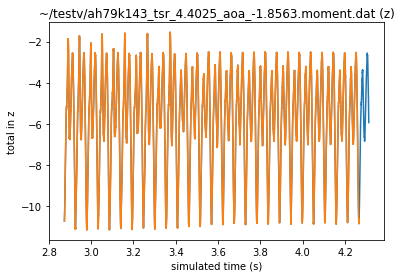

In [17]:
omega =4.4025*40/3
values = analyze('~/testv/ah79k143_tsr_4.4025_aoa_-1.8563.moment.dat', omega, 'z', plot=True)
calc_cp(values, omega)